In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

Loading datasets

In [2]:
df_train = pd.read_feather("../../../data/processed/Churn_6_train_set.feather")

In [3]:
df_opt = pd.read_feather("../../../data/processed/Churn_6_optimization_set.feather")

In [4]:
df_val = pd.read_feather("../../../data/processed/Churn_6_validation_set.feather")

split X, y 

In [5]:
X_train = df_train.drop(["BAJA_6m", "DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window"], axis=1)
y_train = df_train["BAJA_6m"]
del df_train

In [6]:
X_opt = df_opt.drop(["BAJA_6m", "DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window"], axis=1)
y_opt = df_opt["BAJA_6m"]
del df_opt

In [7]:
X_val = df_val.drop(["BAJA_6m", "DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window"], axis=1)
y_val = df_val["BAJA_6m"]
del df_val

Dummifying

In [8]:
X_train = pd.get_dummies(X_train)
X_train = X_train.fillna(-999)

In [9]:
cols = list(X_train.columns)

In [10]:
X_opt = pd.get_dummies(X_opt)
X_opt = X_opt.fillna(-999)
for col in [col for col in X_train.columns if col not in X_opt.columns]:
    X_opt[col] = -999

In [11]:
X_opt = X_opt.drop([col for col in X_opt.columns if col not in X_train.columns], axis=1)

In [12]:
X_val = pd.get_dummies(X_val)
X_val = X_val.fillna(-999)
for col in [col for col in X_train.columns if col not in X_val.columns]:
    X_val[col] = -999

In [13]:
X_val = X_val.drop([col for col in X_val.columns if col not in X_train.columns], axis=1)

In [14]:
for y in [y_train, y_opt, y_val]:
    print(y.value_counts())

False    814711
True      15395
Name: BAJA_6m, dtype: int64
False    273211
True       5575
Name: BAJA_6m, dtype: int64
False    272957
True       5742
Name: BAJA_6m, dtype: int64


In [15]:
len(X_opt.columns) 

458

In [16]:
len(X_train.columns)

458

In [17]:
len(X_val.columns)

458

## Training

In [18]:
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.metrics import f1_score, roc_auc_score 
from numpy.random import RandomState
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from tqdm import tqdm_notebook as tqdm

In [19]:
from sklearn.utils.class_weight import compute_class_weight 

In [20]:
compute_class_weight("balanced", y_train.unique(), y_train)

array([ 0.50944814, 26.96024683])

In [21]:
space = {
    "algo": hp.choice("algo", [RandomForestClassifier, ExtraTreesClassifier]),
    "params": {
        "n_estimators": hp.choice("n_estimators", [40, 80, 120]),  # 100, 400
        "min_samples_leaf": hp.choice("min_samples_leaf", [4, 55]), # , 65
        "max_depth": hp.choice("max_depth", [5,  15]), # 10,
        "max_features": hp.choice("max_features", ['sqrt', 0.5, None]),
        "class_weight": hp.choice("class_weight", [{0:1, 1:20}, {0:1, 1:30},  {0:1, 1:40}]) ,
        "verbose": 2,
        "n_jobs": -1,
    }
}

In [22]:
evals = 30
pbar = tqdm(total=evals)

def __optimizerFunc(args):
    pbar.update(0.5)
    model = args["algo"](**args["params"])
    print(f"Trying: {model}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_opt) 
    pbar.update(0.5)
    # greater is better
    return {"loss": -roc_auc_score(y_opt, y_pred), "status": STATUS_OK,}
          
trials = Trials()
__bestClassifier = fmin(fn=__optimizerFunc,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=evals,
                        trials=trials,
                        rstate=RandomState(42)
                        )
pbar.close()

print("{}\n".format(trials.results))

Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 80building tree 2 of 80building tree 3 of 80building tree 4 of 80building tree 5 of 80building tree 6 of 80building tree 7 of 80building tree 8 of 80







building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min



building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building t

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=15, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=120, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 120building tree 2 of 120building tree 3 of 120building tree 4 of 120building tree 5 of 120building tree 6 of 120building tree 7 of 120building tree 8 of 120







building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min



building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 7

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 12.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    1.0s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=15, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=-1, oob_score=False,
            random_state=None, verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 120building tree 2 of 120building tree 3 of 120building tree 4 of 120building tree 5 of 120building tree 6 of 120
building tree 7 of 120

building tree 8 of 120




building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120building tree 28 of 120

building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.5s


building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    1.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 20},
           criterion='gini', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40building tree 8 of 40







building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40building tree 32 of 40



[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min


building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 80building tree 2 of 80building tree 3 of 80building tree 4 of 80building tree 5 of 80building tree 6 of 80building tree 7 of 80building tree 8 of 80







building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.4min


building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tr

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 16.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.6s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 80building tree 2 of 80building tree 3 of 80building tree 4 of 80building tree 5 of 80building tree 6 of 80
building tree 7 of 80building tree 8 of 80






building tree 9 of 80
building tree 10 of 80building tree 11 of 80

building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min



building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building t

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40building tree 8 of 40







building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min


building tree 33 of 40building tree 34 of 40

building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=-1, oob_score=False,
            random_state=None, verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 120building tree 2 of 120building tree 3 of 120building tree 4 of 120building tree 5 of 120building tree 6 of 120
building tree 7 of 120building tree 8 of 120






building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min


building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.4s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
            criterion='gini', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
            verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40
building tree 8 of 40






building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40building tree 21 of 40

building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40building tree 30 of 40

building tree 31 of 40
building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.3s


building tree 33 of 40
building tree 34 of 40building tree 35 of 40

building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40building tree 8 of 40







building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min



building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=-1, oob_score=False,
            random_state=None, verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 120building tree 2 of 120building tree 3 of 120building tree 4 of 120building tree 5 of 120building tree 6 of 120building tree 7 of 120building tree 8 of 120







building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s



building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 7

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   33.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.5s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40building tree 8 of 40







building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40building tree 31 of 40

building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s


building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=15, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=-1, oob_score=False, random_state=None,
            verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 80building tree 2 of 80building tree 3 of 80building tree 4 of 80building tree 5 of 80building tree 6 of 80building tree 7 of 80building tree 8 of 80







building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min



building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building t

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 13.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.7s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=15, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40
building tree 7 of 40
building tree 8 of 40





building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min


building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 20},
            criterion='gini', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
            verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40
building tree 4 of 40building tree 5 of 40building tree 6 of 40
building tree 7 of 40

building tree 8 of 40



building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40building tree 31 of 40

building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s


building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40building tree 37 of 40

building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 20},
           criterion='gini', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40building tree 8 of 40







building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min


building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=120, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 120building tree 2 of 120building tree 3 of 120building tree 4 of 120building tree 5 of 120building tree 6 of 120building tree 7 of 120building tree 8 of 120







building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.6min


building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 24.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    0.9s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 20},
           criterion='gini', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40
building tree 6 of 40
building tree 7 of 40building tree 8 of 40





building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.5min


building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  8.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40
building tree 8 of 40






building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40building tree 13 of 40

building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s



building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=15, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40building tree 8 of 40







building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.3s



building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   29.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40building tree 8 of 40







building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min


building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40building tree 8 of 40







building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min



building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40


building tree 7 of 40building tree 8 of 40




building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min



building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40

building tree 8 of 40





building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min


building tree 33 of 40
building tree 34 of 40
building tree 35 of 40building tree 36 of 40

building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40
building tree 8 of 40






building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min


building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40building tree 8 of 40







building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min


building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 80building tree 2 of 80building tree 3 of 80building tree 4 of 80building tree 5 of 80building tree 6 of 80building tree 7 of 80building tree 8 of 80







building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min


building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tr

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40building tree 8 of 40







building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min



building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


Trying: ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 40},
           criterion='gini', max_depth=5, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=None,
           verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 80building tree 2 of 80building tree 3 of 80building tree 4 of 80building tree 5 of 80building tree 6 of 80building tree 7 of 80building tree 8 of 80







building tree 9 of 80
building tree 10 of 80building tree 11 of 80

building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min


building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tr

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.3s finished


Trying: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=5, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
            verbose=2, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40building tree 8 of 40







building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min



building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished



[{'loss': -0.5066740111984606, 'status': 'ok'}, {'loss': -0.5082136937378825, 'status': 'ok'}, {'loss': -0.5002251361991232, 'status': 'ok'}, {'loss': -0.500199514975966, 'status': 'ok'}, {'loss': -0.5040421801162795, 'status': 'ok'}, {'loss': -0.5048103559244187, 'status': 'ok'}, {'loss': -0.5107635726870408, 'status': 'ok'}, {'loss': -0.5019676511787166, 'status': 'ok'}, {'loss': -0.5000677250502342, 'status': 'ok'}, {'loss': -0.5100129296082909, 'status': 'ok'}, {'loss': -0.507649684117893, 'status': 'ok'}, {'loss': -0.5001007020756785, 'status': 'ok'}, {'loss': -0.5002928612493575, 'status': 'ok'}, {'loss': -0.5092370080169152, 'status': 'ok'}, {'loss': -0.5, 'status': 'ok'}, {'loss': -0.5002745603756737, 'status': 'ok'}, {'loss': -0.5009500871490887, 'status': 'ok'}, {'loss': -0.5002782441856196, 'status': 'ok'}, {'loss': -0.501006748951881, 'status': 'ok'}, {'loss': -0.5004594464702974, 'status': 'ok'}, {'loss': -0.5076185135446079, 'status': 'ok'}, {'loss': -0.5093210502246058,

In [25]:
print("Best Config:")
opt_config = space_eval(space, __bestClassifier)
print(opt_config)

Best Config:
{'algo': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'params': {'class_weight': {0: 1, 1: 40}, 'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 4, 'n_estimators': 40, 'n_jobs': -1, 'verbose': 2}}


In [29]:
rf = opt_config['algo'](**opt_config['params'])

In [30]:
rf

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=5, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
            verbose=2, warm_start=False)

In [32]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40building tree 3 of 40building tree 4 of 40building tree 5 of 40building tree 6 of 40building tree 7 of 40

building tree 8 of 40





building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min


building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.6min finished


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 40},
            criterion='gini', max_depth=5, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
            verbose=2, warm_start=False)

---

### Feature importance

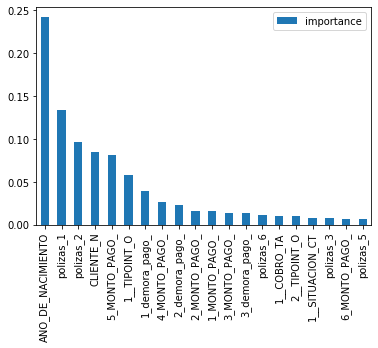

In [33]:
pd.DataFrame(rf.feature_importances_,index=X_train.columns, columns=['importance']
                                   ).sort_values('importance', ascending=False).iloc[0:20].plot.bar()

**REVIEW THIS LATER**

In [34]:
predictions = rf.predict(X_val)
pd.Series(predictions).value_counts()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


False    265919
True      12780
dtype: int64

In [35]:
import seaborn as sns

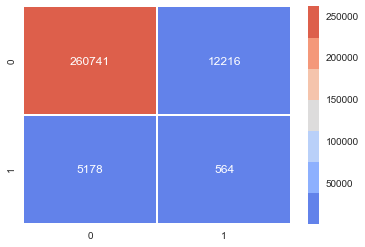

In [36]:
cmap = sns.color_palette("coolwarm", 7)
sns.set(font_scale=1)
sns.heatmap(confusion_matrix(y_val, predictions), annot=True, fmt="d", linewidths=.5, cmap=cmap) 

In [37]:
print(f'ROC AUC: {roc_auc_score(y_val, predictions)} ') 

ROC AUC: 0.5267346567526727 


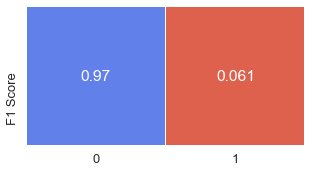

In [38]:
data = pd.DataFrame(columns=range(2), data=[f1_score(y_val, predictions, average=None)])
data.index = ["F1 Score"]
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(5,5))
sns.set(font_scale=1.3)
cmap = sns.color_palette("coolwarm_r", 7)
sns.heatmap(data, annot=True, linewidths=.5, cmap=cmap, square=True, cbar=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


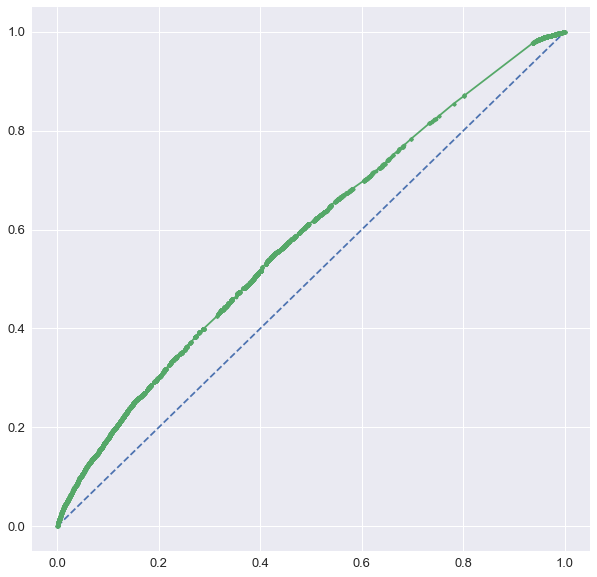

In [39]:
from sklearn.metrics import roc_curve

probs = rf.predict_proba(X_val)
probs = probs[:, 1]
fig=plt.figure(figsize=(10,10))
fpr, tpr, thresholds = roc_curve(y_val, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Dumping model

In [40]:
import pickle

In [42]:
with open('../../../src/models/Churn6-Hyperotimization-Dummies.md', 'wb') as file:
    pickle.dump(rf, file, pickle.HIGHEST_PROTOCOL)